# Google Earth Engine

import Tag from '@site/src/components/Tag'

Fused interfaces <Tag color="#3399ff">Google Earth Engine</Tag> through the Python `earthengine-api` library. This example shows how to load data from [Google Earth Engine](https://developers.google.com/earth-engine/datasets) into your Fused UDFs.

The GEE library requires Service Accunt credentials to be set. Read how to create them in the Google Earth Engine documentation, and set `key_path` as the path of the key json.

In [ ]:
# !pip install fused earthengine-api xarray xee

In [9]:
import fused


@fused.udf
def udf(bbox=None, n=10):
    import ee
    import xarray

    utils = fused.load(
        "https://github.com/fusedio/udfs/tree/f928ee1/public/common/"
    ).utils

    # Authenticate GEE
    key_path = "/path/key.json"
    credentials = ee.ServiceAccountCredentials(
        "fused-account@fused-gee.iam.gserviceaccount.com", key_path
    )
    ee.Initialize(
        opt_url="https://earthengine-highvolume.googleapis.com", credentials=credentials
    )

    # Generate GEE bounding box for spatial filter
    geom = ee.Geometry.Rectangle(*bbox.total_bounds)
    scale = 1 / 2 ** max(
        0, bbox.z[0]
    )  # A larger scale will increase your resolution per z but slow down the loading

    # Load data from a GEE ImageCollection
    ic = ee.ImageCollection("MODIS/061/MOD13A2").filter(
        ee.Filter.date("2023-01-01", "2023-06-01")
    )

    # Open with xarray (the `xee` package must be present for engine="ee" to work)
    ds = xarray.open_dataset(ic, engine="ee", geometry=geom, scale=scale).isel(time=0)

    # Transform image color with a utility function
    arr = utils.arr_to_plasma(ds["NDVI"].values.squeeze().T, min_max=(0, 8000))
    return arr


arr = fused.run(udf=udf, x=35, y=54, z=7, engine="local")
arr

array([[[ 94,  84,  78, ..., 239, 239, 239],
        [ 76,  33,  43, ..., 239, 239, 239],
        [ 52,  58,  58, ..., 239, 239, 239],
        ...,
        [239, 239, 239, ..., 239, 239, 239],
        [239, 239, 239, ..., 239, 239, 239],
        [239, 239, 239, ..., 239, 239, 239]],

       [[  0,   1,   2, ..., 248, 248, 248],
        [  2,   5,   5, ..., 248, 248, 248],
        [  4,   4,   4, ..., 248, 248, 248],
        ...,
        [248, 248, 248, ..., 248, 248, 248],
        [248, 248, 248, ..., 248, 248, 248],
        [248, 248, 248, ..., 248, 248, 248]],

       [[165, 163, 161, ...,  33,  33,  33],
        [161, 143, 148, ...,  33,  33,  33],
        [152, 154, 154, ...,  33,  33,  33],
        ...,
        [ 33,  33,  33, ...,  33,  33,  33],
        [ 33,  33,  33, ...,  33,  33,  33],
        [ 33,  33,  33, ...,  33,  33,  33]]], dtype=uint8)

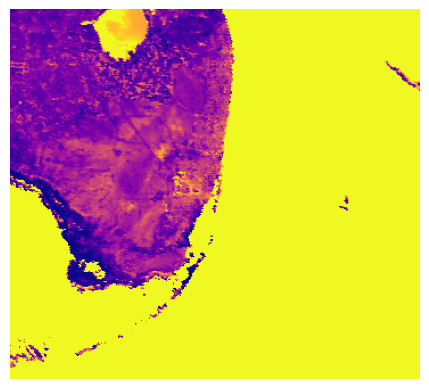

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Transpose the axes to match image format
image_array = np.transpose(arr, (1, 2, 0))

# Display the image
plt.imshow(image_array)
plt.axis("off")  # Optional: turn off axis
plt.show()